In [346]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import openpyxl
import datetime as datetime
from dateutil.relativedelta import relativedelta

In [347]:
ser = pd.read_csv('serbyli_CLEAN.csv')
fjol = pd.read_csv('fjolbyli_CLEAN.csv')
variables = pd.read_csv('merged_variables.csv')

In [348]:
skuldir = pd.read_excel('sedlabankinn_heimili.xlsx', sheet_name='VII-11', skiprows=11)
kaupsamningar = pd.read_excel('sedlabankinn_eignamarkadir.xlsx', sheet_name='VI-1', skiprows=11)
frambod = pd.read_excel('sedlabankinn_eignamarkadir.xlsx', sheet_name='VI-9', skiprows=11)


In [367]:
indep = pd.read_csv('independent_variables_LSTM.csv', date_parser=True)
indep.head()

,date,Reykjavík,Kópavogur,Garðabær,Hafnarfjörður,Mosfellsbær,"Eigendur, skuldlaust",Eigendur m. lán,"Leigjendur, alls",overdtryggt,verdtryggt,visitala_rvk_%,verdbolga_%
0,2006-01-01,0.426536,0.422639,0.466222,0.385545,0.351291,18.000,64.80,17.200,12.5,4.15,0.5,-0.259179
1,2006-02-01,0.426689,0.422375,0.468374,0.387134,0.352263,17.675,65.15,17.175,12.5,4.15,2.0,-0.259179
2,2006-03-01,0.426842,0.422111,0.470526,0.388724,0.353236,17.350,65.50,17.150,12.5,4.15,1.7,1.169337
3,2006-04-01,0.426995,0.421847,0.472678,0.390313,0.354208,17.025,65.85,17.125,12.5,4.30,1.2,1.070205
4,2006-05-01,0.427148,0.421584,0.474830,0.391902,0.355180,16.700,66.20,17.100,13.0,4.60,-0.2,1.482423


In [349]:
skuldir.rename(columns={'Unnamed: 0':'date'}, inplace=True)
skuldir['date'] = skuldir['date'].str.replace('F', '-')
skuldir['date'] = pd.to_datetime(skuldir['date'])
skuldir.head()

,date,Verðtryggð lán,Lán í erl. gjaldm.,Óverðtryggð lán,Yfirdráttarlán,Eignaleigusamningar
0,2005-01-01,80.70,2.43,3.79,6.10,1.08
1,2005-02-01,81.81,2.91,3.62,6.42,1.43
2,2005-03-01,85.04,2.89,3.60,6.16,1.75
3,2005-04-01,87.38,3.14,2.88,6.43,2.08
4,2006-01-01,87.68,4.03,3.97,6.59,3.25


In [350]:
skuldir2 = skuldir['date']

In [351]:
period_2 = skuldir.date + pd.DateOffset(months=4)
period_3 = skuldir.date + pd.DateOffset(months=8)
periods = pd.merge(period_2, period_3, how='outer')
skuld = pd.merge(skuldir, periods, how='outer')
skuld.sort_values('date', inplace=True)
skuld

,date,Verðtryggð lán,Lán í erl. gjaldm.,Óverðtryggð lán,Yfirdráttarlán,Eignaleigusamningar
0,2005-01-01,80.70,2.43,3.79,6.10,1.08
1,2005-02-01,81.81,2.91,3.62,6.42,1.43
2,2005-03-01,85.04,2.89,3.60,6.16,1.75
3,2005-04-01,87.38,3.14,2.88,6.43,2.08
68,2005-05-01,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
135,2021-08-01,NaN,NaN,NaN,NaN,NaN
200,2021-09-01,NaN,NaN,NaN,NaN,NaN
201,2021-10-01,NaN,NaN,NaN,NaN,NaN
202,2021-11-01,NaN,NaN,NaN,NaN,NaN


In [352]:
skuld[['Verðtryggð lán','Lán í erl. gjaldm.', 'Óverðtryggð lán']] = skuld[['Verðtryggð lán','Lán í erl. gjaldm.', 'Óverðtryggð lán']].interpolate()
skuldir = skuld[['date','Verðtryggð lán','Lán í erl. gjaldm.', 'Óverðtryggð lán']]
skuldir.head()

,date,Verðtryggð lán,Lán í erl. gjaldm.,Óverðtryggð lán
0,2005-01-01,80.700000,2.430000,3.790000
1,2005-02-01,81.810000,2.910000,3.620000
2,2005-03-01,85.040000,2.890000,3.600000
3,2005-04-01,87.380000,3.140000,2.880000
68,2005-05-01,87.413333,3.238889,3.001111


<AxesSubplot:xlabel='date'>

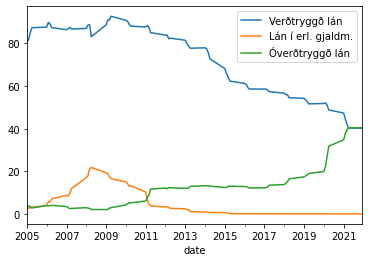

In [353]:
skuldir.set_index('date').plot()

In [354]:
kaupsamningar.rename(columns={'Unnamed: 0':'date'},inplace=True)
frambod.rename(columns={'Unnamed: 0':'date'},inplace=True)

In [355]:
samningar = pd.merge(kaupsamningar, frambod, how='left', on='date')

In [356]:
data = pd.merge(samningar, skuldir, how='left', on='date')

In [357]:
data = data.iloc[75:]

In [358]:
data.isna().sum()

date                                              0
Fjöldi kaupsamninga, árstíðarleiðrétt (v. ás)     4
Íbúðaverð (h. ás)                                 4
Raunverð íbúða (h. ás)                            4
Einbýli/raðhús/parhús (v. ás)                     7
Fjölbýli/hæðir (v. ás)                            7
Aðrar fasteignir (atvinnuhús o.fl.) (v. ás)       7
Meðalsölutími íbúðarhúsnæðis (h. ás)             19
Verðtryggð lán                                    6
Lán í erl. gjaldm.                                6
Óverðtryggð lán                                   6
dtype: int64

<AxesSubplot:ylabel='date'>

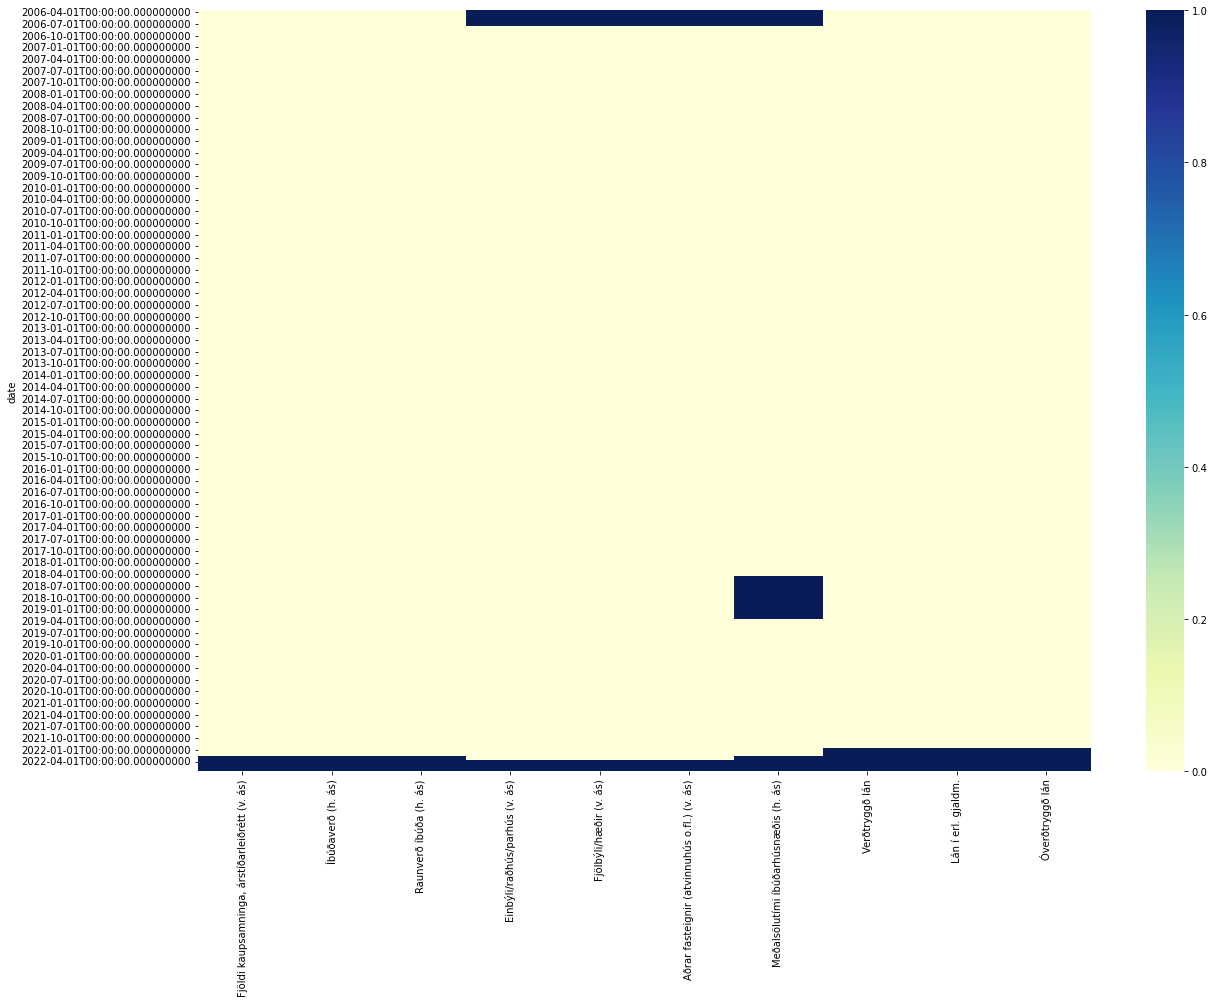

In [359]:
plt.figure(figsize=(20,14))
sns.heatmap(data.set_index('date').isna(), cmap="YlGnBu")

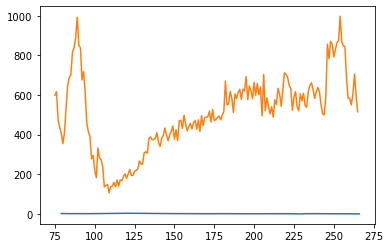

In [362]:
plt.plot(data[['Fjölbýli/hæðir (v. ás)', 'Fjöldi kaupsamninga, árstíðarleiðrétt (v. ás)']])

In [ ]:
 bad_idx = data.index[data['Fjölbýli/hæðir (v. ás)'].pct_change().abs().ge(0.5)]
 data.loc[(data.index >= bad_idx.min()) & (data.index < bad_idx.max()), 'Fjölbýli/hæðir (v. ás)'] = np.nan
 data['Fjölbýli/hæðir (v. ás)'] = data['Fjölbýli/hæðir (v. ás)'].interpolate()

In [306]:
data.set_index('date').interpolate().isna().sum()

Fjöldi kaupsamninga, árstíðarleiðrétt (v. ás)    0
Íbúðaverð (h. ás)                                0
Raunverð íbúða (h. ás)                           0
Einbýli/raðhús/parhús (v. ás)                    4
Fjölbýli/hæðir (v. ás)                           4
Aðrar fasteignir (atvinnuhús o.fl.) (v. ás)      4
Meðalsölutími íbúðarhúsnæðis (h. ás)             4
Verðtryggð lán                                   0
Lán í erl. gjaldm.                               0
Óverðtryggð lán                                  0
dtype: int64

In [307]:
data = data.set_index('date').interpolate()

In [308]:
data = data.bfill()

In [309]:
data.isna().sum()

Fjöldi kaupsamninga, árstíðarleiðrétt (v. ás)    0
Íbúðaverð (h. ás)                                0
Raunverð íbúða (h. ás)                           0
Einbýli/raðhús/parhús (v. ás)                    0
Fjölbýli/hæðir (v. ás)                           0
Aðrar fasteignir (atvinnuhús o.fl.) (v. ás)      0
Meðalsölutími íbúðarhúsnæðis (h. ás)             0
Verðtryggð lán                                   0
Lán í erl. gjaldm.                               0
Óverðtryggð lán                                  0
dtype: int64

In [310]:
data.to_csv('sedlabankinn_CLEAN.csv')

In [311]:
variables['date'] = pd.to_datetime(variables['date'])
fjol['utgdag'] = pd.to_datetime(fjol['utgdag'])
ser['utgdag'] = pd.to_datetime(ser['utgdag'])

In [312]:
all_variables = pd.merge(data, variables, how='left', on='date')

In [313]:
all_variables.dropna(inplace=True) #sleppa júní 2022

In [314]:
all_variables.columns

Index(['date', 'Fjöldi kaupsamninga, árstíðarleiðrétt (v. ás)',
       'Íbúðaverð (h. ás)', 'Raunverð íbúða (h. ás)',
       'Einbýli/raðhús/parhús (v. ás)', 'Fjölbýli/hæðir (v. ás)',
       'Aðrar fasteignir (atvinnuhús o.fl.) (v. ás)',
       'Meðalsölutími íbúðarhúsnæðis (h. ás)', 'Verðtryggð lán',
       'Lán í erl. gjaldm.', 'Óverðtryggð lán', 'Unnamed: 0', 'overdtryggt',
       'verdtryggt', 'visitala_rvk_%', 'verdbolga_%'],
      dtype='object')

In [315]:
all_variables.drop(['Íbúðaverð (h. ás)', 'Raunverð íbúða (h. ás)', 'Aðrar fasteignir (atvinnuhús o.fl.) (v. ás)', 'Unnamed: 0'],axis=1,inplace=True)

In [316]:
all_variables.rename(columns={'Fjöldi kaupsamninga, árstíðarleiðrétt (v. ás)':'fjöldi_kaupsamninga', 'Einbýli/raðhús/parhús (v. ás)':'auglyst_serbyli', 'Fjölbýli/hæðir (v. ás)':'auglyst_fjolbyli', 'Meðalsölutími íbúðarhúsnæðis (h. ás)':'solutimi', 'Lán í erl. gjaldm.': 'erlend_lan'}, inplace=True)

In [373]:
all_variables['date'] = pd.to_datetime(all_variables['date'])
indep['date'] = pd.to_datetime(indep['date'])

In [378]:
indep.drop(['overdtryggt', 'verdtryggt', 'visitala_rvk_%', 'verdbolga_%'], axis=1)

,date,Reykjavík,Kópavogur,Garðabær,Hafnarfjörður,Mosfellsbær,"Eigendur, skuldlaust",Eigendur m. lán,"Leigjendur, alls"
0,2006-01-01,0.426536,0.422639,0.466222,0.385545,0.351291,18.000,64.80,17.200
1,2006-02-01,0.426689,0.422375,0.468374,0.387134,0.352263,17.675,65.15,17.175
2,2006-03-01,0.426842,0.422111,0.470526,0.388724,0.353236,17.350,65.50,17.150
3,2006-04-01,0.426995,0.421847,0.472678,0.390313,0.354208,17.025,65.85,17.125
4,2006-05-01,0.427148,0.421584,0.474830,0.391902,0.355180,16.700,66.20,17.100
...,...,...,...,...,...,...,...,...,...
192,2022-01-01,0.427761,0.386199,0.382488,0.368074,0.341139,20.400,56.50,21.700
193,2022-02-01,0.427761,0.386199,0.382488,0.368074,0.341139,20.400,56.50,21.700
194,2022-03-01,0.427761,0.386199,0.382488,0.368074,0.341139,20.400,56.50,21.700
195,2022-04-01,0.427761,0.386199,0.382488,0.368074,0.341139,20.400,56.50,21.700


In [379]:
all_independent_variables = pd.merge(all_variables, indep.drop(['overdtryggt', 'verdtryggt', 'visitala_rvk_%', 'verdbolga_%'], axis=1), how='inner', on='date')
all_independent_variables

,date,fjöldi_kaupsamninga,auglyst_serbyli,auglyst_fjolbyli,solutimi,Verðtryggð lán,erlend_lan,Óverðtryggð lán,overdtryggt,verdtryggt,visitala_rvk_%,verdbolga_%,Reykjavík,Kópavogur,Garðabær,Hafnarfjörður,Mosfellsbær,"Eigendur, skuldlaust",Eigendur m. lán,"Leigjendur, alls"
0,2006-04-01,598.40,0.48,2.05,6.21,87.42,7.19,4.07,12.50,4.30,1.2,1.070205,0.426995,0.421847,0.472678,0.390313,0.354208,17.025,65.85,17.125
1,2006-05-01,617.00,0.48,2.05,6.21,87.31,7.36,4.01,13.00,4.60,-0.2,1.482423,0.427148,0.421584,0.474830,0.391902,0.355180,16.700,66.20,17.100
2,2006-06-01,472.74,0.48,2.05,6.21,87.20,7.53,3.95,14.00,4.60,0.6,1.001669,0.427300,0.421320,0.476982,0.393491,0.356153,16.375,66.55,17.075
3,2006-07-01,436.96,0.48,2.05,6.21,87.09,7.70,3.89,14.00,4.60,-1.7,0.413223,0.427453,0.421056,0.479134,0.395080,0.357125,16.050,66.90,17.050
4,2006-08-01,406.92,0.48,2.05,6.21,86.98,7.87,3.83,14.50,4.85,2.4,0.288066,0.427606,0.420792,0.481286,0.396669,0.358097,15.725,67.25,17.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,2022-01-01,598.23,0.12,0.35,0.79,40.28,0.07,40.45,3.95,1.50,1.7,0.161253,0.427761,0.386199,0.382488,0.368074,0.341139,20.400,56.50,21.700
190,2022-02-01,516.03,0.13,0.32,0.88,40.28,0.07,40.45,4.15,1.50,2.5,1.264949,0.427761,0.386199,0.382488,0.368074,0.341139,20.400,56.50,21.700
191,2022-03-01,516.03,0.12,0.38,0.88,40.28,0.07,40.45,4.15,1.50,3.1,0.817624,0.427761,0.386199,0.382488,0.368074,0.341139,20.400,56.50,21.700
192,2022-04-01,516.03,0.12,0.38,0.88,40.28,0.07,40.45,4.15,1.49,2.7,0.991214,0.427761,0.386199,0.382488,0.368074,0.341139,20.400,56.50,21.700


In [ ]:
all_independent_variables.to_csv('20_independent_variables_LSTM.csv')

In [317]:
fjolbyli = pd.merge(fjol, all_variables, how='left', left_on='utgdag', right_on='date')
serbyli = pd.merge(ser, all_variables, how='left', left_on='utgdag', right_on='date')

In [318]:
fjolbyli.columns

Index(['Unnamed: 0', 'utgdag', 'kaupverd', 'fasteignamat', 'byggar', 'einflm',
       'lod_flm', 'fullbuid', 'postnr_101.0', 'postnr_102.0', 'postnr_103.0',
       'postnr_104.0', 'postnr_105.0', 'postnr_107.0', 'postnr_108.0',
       'postnr_109.0', 'postnr_110.0', 'postnr_111.0', 'postnr_112.0',
       'postnr_113.0', 'postnr_116.0', 'postnr_200.0', 'postnr_201.0',
       'postnr_203.0', 'postnr_206.0', 'postnr_220.0', 'postnr_221.0',
       'postnr_270.0', 'postnr_271.0', 'sveitarfelag_Hafnarfjarðarkaupstaður',
       'sveitarfelag_Kópavogsbær', 'sveitarfelag_Mosfellsbær',
       'sveitarfelag_Reykjavíkurborg', 'date', 'fjöldi_kaupsamninga',
       'auglyst_serbyli', 'auglyst_fjolbyli', 'solutimi', 'Verðtryggð lán',
       'erlend_lan', 'Óverðtryggð lán', 'overdtryggt', 'verdtryggt',
       'visitala_rvk_%', 'verdbolga_%'],
      dtype='object')

In [319]:
fjolbyli.drop(['Unnamed: 0', 'utgdag', 'auglyst_serbyli'], axis=1, inplace=True)
fjolbyli.set_index('date', inplace=True)

In [320]:
serbyli.columns

Index(['Unnamed: 0', 'utgdag', 'kaupverd', 'fasteignamat', 'byggar', 'einflm',
       'lod_flm', 'fullbuid', 'postnr_101.0', 'postnr_102.0', 'postnr_103.0',
       'postnr_104.0', 'postnr_105.0', 'postnr_107.0', 'postnr_108.0',
       'postnr_109.0', 'postnr_110.0', 'postnr_111.0', 'postnr_112.0',
       'postnr_113.0', 'postnr_116.0', 'postnr_200.0', 'postnr_201.0',
       'postnr_203.0', 'postnr_206.0', 'postnr_220.0', 'postnr_221.0',
       'postnr_270.0', 'postnr_271.0', 'sveitarfelag_Hafnarfjarðarkaupstaður',
       'sveitarfelag_Kópavogsbær', 'sveitarfelag_Mosfellsbær',
       'sveitarfelag_Reykjavíkurborg', 'date', 'fjöldi_kaupsamninga',
       'auglyst_serbyli', 'auglyst_fjolbyli', 'solutimi', 'Verðtryggð lán',
       'erlend_lan', 'Óverðtryggð lán', 'overdtryggt', 'verdtryggt',
       'visitala_rvk_%', 'verdbolga_%'],
      dtype='object')

In [321]:
serbyli.drop(['Unnamed: 0', 'utgdag', 'auglyst_fjolbyli'], axis=1, inplace=True)
serbyli.set_index('date', inplace=True)

In [322]:
serbyli

,kaupverd,fasteignamat,byggar,einflm,lod_flm,fullbuid,postnr_101.0,postnr_102.0,postnr_103.0,postnr_104.0,...,fjöldi_kaupsamninga,auglyst_serbyli,solutimi,Verðtryggð lán,erlend_lan,Óverðtryggð lán,overdtryggt,verdtryggt,visitala_rvk_%,verdbolga_%
date,,,,,,,,,,,,,,,,,,,,,
2006-04-01,24700,19820,1988,112.3,1285.0,1,0,0,0,0,...,598.40,0.48,6.21,87.42,7.19,4.07,12.50,4.30,1.2,1.070205
2006-05-01,11900,12090,1972,78.1,7940.0,1,0,0,0,0,...,617.00,0.48,6.21,87.31,7.36,4.01,13.00,4.60,-0.2,1.482423
2006-05-01,17300,15110,1993,89.0,1339.0,1,0,0,0,0,...,617.00,0.48,6.21,87.31,7.36,4.01,13.00,4.60,-0.2,1.482423
2006-05-01,19200,14725,1956,88.3,6106.0,1,0,0,0,0,...,617.00,0.48,6.21,87.31,7.36,4.01,13.00,4.60,-0.2,1.482423
2006-05-01,18100,15940,1907,90.3,204.0,1,1,0,0,0,...,617.00,0.48,6.21,87.31,7.36,4.01,13.00,4.60,-0.2,1.482423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,114990,73750,2021,161.0,8086.0,1,0,0,0,0,...,516.03,0.12,0.88,40.28,0.07,40.45,4.65,1.49,2.7,0.423823
2022-05-01,56900,29450,2021,90.2,4214.0,1,0,0,1,0,...,516.03,0.12,0.88,40.28,0.07,40.45,4.65,1.49,2.7,0.423823
2022-05-01,64500,49200,1974,134.3,5002.0,1,0,0,0,0,...,516.03,0.12,0.88,40.28,0.07,40.45,4.65,1.49,2.7,0.423823


In [326]:
fjol['verd_m2'] = fjol['kaupverd'] / fjol['einflm']
ser['verd_m2'] = ser['kaupverd'] / ser['einflm']
ser_mean = ser.groupby('utgdag').mean()
fjol_mean = fjol.groupby('utgdag').mean()

In [327]:
ser_mean
fjol_mean

,Unnamed: 0,kaupverd,fasteignamat,byggar,einflm,lod_flm,fullbuid,postnr_101.0,postnr_102.0,postnr_103.0,...,postnr_206.0,postnr_220.0,postnr_221.0,postnr_270.0,postnr_271.0,sveitarfelag_Hafnarfjarðarkaupstaður,sveitarfelag_Kópavogsbær,sveitarfelag_Mosfellsbær,sveitarfelag_Reykjavíkurborg,verd_m2
utgdag,,,,,,,,,,,,,,,,,,,,,
2006-03-01,86686.000000,11050.000000,17330.000000,1958.000000,224.000000,7000.000000,1.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,49.330357
2006-04-01,112433.000000,65000.000000,43800.000000,2003.000000,290.700000,632.800000,1.0,0.000000,0.000000,0.0,...,0.0,0.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,223.598211
2006-06-01,74695.972973,37820.270270,28738.648649,1977.243243,173.518919,1695.443243,1.0,0.027027,0.000000,0.0,...,0.0,0.054054,0.081081,0.162162,0.0,0.135135,0.189189,0.162162,0.513514,222.630116
2006-07-01,78291.906250,42292.187500,31139.187500,1973.343750,187.431250,1315.950000,1.0,0.062500,0.000000,0.0,...,0.0,0.093750,0.031250,0.062500,0.0,0.125000,0.125000,0.062500,0.687500,231.063339
2006-08-01,59286.068966,38737.931034,29353.275862,1966.000000,176.651724,991.982759,1.0,0.103448,0.068966,0.0,...,0.0,0.068966,0.068966,0.103448,0.0,0.137931,0.275862,0.103448,0.482759,226.015105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,83021.368421,97816.052632,72961.447368,1980.486842,193.510526,1551.919737,1.0,0.039474,0.000000,0.0,...,0.0,0.131579,0.144737,0.105263,0.0,0.276316,0.105263,0.105263,0.513158,522.140885
2022-02-01,81386.180000,101761.000000,79659.600000,1978.320000,202.034000,1117.332000,1.0,0.040000,0.000000,0.0,...,0.0,0.180000,0.060000,0.120000,0.0,0.240000,0.180000,0.120000,0.460000,529.559932
2022-03-01,79682.745098,102001.960784,78200.000000,1979.960784,185.774510,1191.400000,1.0,0.039216,0.000000,0.0,...,0.0,0.117647,0.078431,0.137255,0.0,0.196078,0.235294,0.137255,0.431373,590.712389


In [328]:
fjolbyli_mean = pd.merge(fjol_mean, all_variables, how='left', left_on='utgdag', right_on='date')
serbyli_mean = pd.merge(ser_mean, all_variables, how='left', left_on='utgdag', right_on='date')

In [330]:
fjolbyli_mean.drop(['Unnamed: 0', 'auglyst_serbyli'], axis=1, inplace=True)
fjolbyli_mean.set_index('date', inplace=True)

In [331]:
serbyli_mean.drop(['Unnamed: 0', 'auglyst_fjolbyli'], axis=1, inplace=True)
serbyli_mean.set_index('date', inplace=True)

In [341]:
serbyli_mean.dropna(inplace=True)

In [344]:
fjolbyli_mean.to_csv('fjolbyli_all_variables_MEAN.csv')
serbyli_mean.to_csv('serbyli_all_variables_MEAN.csv')


NameError: name 'df' is not defined